# Abstractive Text Summarization on the WikiHow Dataset

## Tanmay Kenjale - 801054629 - ITCS 4111


### Import dependencies

In [1]:
import os
path = os.getcwd()
# Using custom Attention Layer found here: https://github.com/thushv89/attention_keras/blob/master/layers/attention.py
from attention import AttentionLayer
os.chdir(path + '/data')

In [2]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from rouge import Rouge

Using TensorFlow backend.


In [3]:
# Check if GPU is active
tf.test.gpu_device_name()

'/device:GPU:0'

### Read and clean WikiHow Dataset

In [3]:
# Data found here: https://ucsb.app.box.com/s/7yq601ijl1lzvlfu4rjdbbxforzd2oag

df = pd.read_csv('wikihowSep.csv')
df.head()

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [4]:
df.dropna(inplace=True)

In [5]:
texts = []

for text in df['text']:
    text = text.lower()
    text = re.sub('\n', '', text)
    text = re.sub("[^a-zA-Z^']", " ", text)
    text = re.sub(" {2,}", " ", text)
    text = text.strip()
    texts.append(text)

headlines = []

for head in df['headline']:
    head = head.lower()
    head = re.sub('\n', '', head)
    head = re.sub("[^a-zA-Z^']", " ", head)
    head = re.sub(" {2,}", " ", head)
    head = head.strip()
    # Add start and end tags
    head = 'START ' + head + ' END'
    headlines.append(head)

In [6]:
df['clean_text'] = texts
df['clean_headlines'] = headlines
df.head()

,overview,headline,text,sectionLabel,title,clean_text,clean_headlines
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online,before doing anything else stop and sum up you...,START sell yourself first END
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read,reading the classics is the very first thing y...,START read the classics before END
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online,depending on what scale you intend to sell you...,START join online artist communities END
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online,get yourself out there as best as you can by a...,START make yourself public END
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online,given the hundreds of free blogging websites y...,START blog about your artwork END


In [7]:
df_clean = df[['clean_text', 'clean_headlines']]
df_clean.head()

,clean_text,clean_headlines
0,before doing anything else stop and sum up you...,START sell yourself first END
1,reading the classics is the very first thing y...,START read the classics before END
2,depending on what scale you intend to sell you...,START join online artist communities END
3,get yourself out there as best as you can by a...,START make yourself public END
4,given the hundreds of free blogging websites y...,START blog about your artwork END


In [8]:
# Find lenghts of texts and headlines

t_lengths = []
h_lengths = []

for i in range(df_clean['clean_text'].count()):
    try:
        t = len(df_clean['clean_text'][i].split())
        t_lengths.append(t)
    except:
        t_lengths.append(np.nan)
    try:
        h = len(df_clean['clean_headlines'][i].split())
        h_lengths.append(h)
    except:
        h_lengths.append(np.nan)

In [9]:
df_clean['text_len'] = t_lengths
df_clean['headline_len'] = h_lengths
df_clean.dropna(inplace=True)
df_clean.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_gu

,clean_text,clean_headlines,text_len,headline_len
0,before doing anything else stop and sum up you...,START sell yourself first END,114.0,5.0
1,reading the classics is the very first thing y...,START read the classics before END,170.0,6.0
2,depending on what scale you intend to sell you...,START join online artist communities END,255.0,6.0
3,get yourself out there as best as you can by a...,START make yourself public END,199.0,5.0
4,given the hundreds of free blogging websites y...,START blog about your artwork END,170.0,6.0


### Find distribution of text and headline lengths

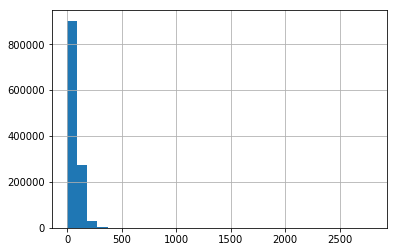

Mean text length:  68.81038522815408
Max text length:  2792.0
Min text length:  0.0


In [10]:
df_clean['text_len'].hist(bins=30)
plt.show()
print('Mean text length: ', df_clean['text_len'].mean())
print('Max text length: ', df_clean['text_len'].max())
print('Min text length: ', df_clean['text_len'].min())

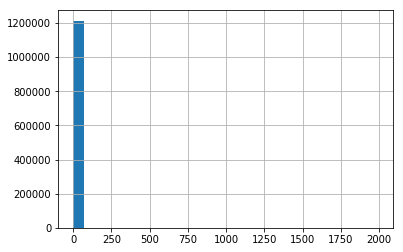

Mean headline length:  9.239013056332375
Max headline length:  1992.0
Min headline length:  2.0


In [11]:
df_clean['headline_len'].hist(bins=30)
plt.show()
print('Mean headline length: ', df_clean['headline_len'].mean())
print('Max headline length: ', df_clean['headline_len'].max())
print('Min headline length: ', df_clean['headline_len'].min())

In [12]:
df_clean.describe()

,text_len,headline_len
count,1.213281e+06,1.213281e+06
mean,6.881039e+01,9.239013e+00
std,5.453138e+01,5.747883e+00
min,0.000000e+00,2.000000e+00
25%,3.000000e+01,6.000000e+00
50%,5.700000e+01,8.000000e+00
75%,9.500000e+01,1.100000e+01
max,2.792000e+03,1.992000e+03


### Delete outliers that have very small or very large lengths

In [13]:
df_red = df_clean[(df_clean['text_len'] >= 10) & (df_clean['text_len'] <= 150)]

In [14]:
df_red = df_red[(df_red['headline_len'] >= 1) & (df_red['headline_len'] <= 20)]

In [15]:
df_red.describe()

,text_len,headline_len
count,1.016549e+06,1.016549e+06
mean,6.277893e+01,8.381164e+00
std,3.583432e+01,3.459645e+00
min,1.000000e+01,2.000000e+00
25%,3.300000e+01,6.000000e+00
50%,5.700000e+01,8.000000e+00
75%,8.800000e+01,1.000000e+01
max,1.500000e+02,2.000000e+01


In [16]:
# Set max content and summary lengths based on outlier removal above
max_content_len = 150
max_summary_len = 20

### Tokenize and convert texts into padded vectors

In [17]:
def convert_to_sequences(data, x):
    if x:
        length = max_content_len
    else:
        length = max_summary_len
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(data))
    sequences = tokenizer.texts_to_sequences(list(data))
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    data = sequences
    voc_size  =  len(tokenizer.word_index) + 1
    return data, voc_size, tokenizer

In [18]:
# Take subset of data (first 100,000 entries) because training takes too long with all the data
x_seqs, x_vocab_size, x_tokenizer = convert_to_sequences(df_red['clean_text'][:100000], True)
y_seqs, y_vocab_size, y_tokenizer = convert_to_sequences(df_red['clean_headlines'][:100000], False)

### Create training and test sets

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_seqs, y_seqs, test_size=0.1, random_state=0, shuffle=True)

### Build Seq2Seq model with Encoder-Decoder Architecture and Attention Layer

In [37]:
K.clear_session()
dim = 500

# Encoder
encoder_in = Input(shape=(max_content_len,), name='Encoder_Input')
encoder_embedding_layer = Embedding(x_vocab_size, dim, trainable=True, name='Encoder_Embedding')(encoder_in)

# LSTM1
lstm1 = LSTM(dim, return_sequences=True, return_state=True, name='LSTM1')
encoder_out1, hidden_state1, cell_state1 = lstm1(encoder_embedding_layer)

# LSTM2
lstm2 = LSTM(dim, return_sequences=True, return_state=True, name='LSTM2')
encoder_out2, hidden_state2, cell_state2 = lstm2(encoder_out1)

# LSTM3
lstm3 = LSTM(dim, return_sequences=True, return_state=True, name='LSTM3')
encoder_out, hidden_state, cell_state = lstm3(encoder_out2)

# Decoder
decoder_in = Input(shape=(None,), name='Decoder_Input')
decoder_embedding_layer = Embedding(y_vocab_size, dim, trainable=True, name='Decoder_Embedding')
decoder_embedding = decoder_embedding_layer(decoder_in)

# Decoder LSTM
decoder_lstm = LSTM(dim, return_sequences=True, return_state=True, name='Decoder_LSTM')
decoder_out, fwd_state, back_state = decoder_lstm(decoder_embedding, initial_state=[hidden_state, cell_state])

# Attention
attention_layer = AttentionLayer(name='Attention_Layer')
a_out, a_states = attention_layer([encoder_out, decoder_out])

# Concatenate
concat_in = Concatenate(axis=-1, name='Concatenate_Layer')([decoder_out, a_out])

# Decoder Dense
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'), name='Dense')
decoder_out = decoder_dense(concat_in)

model = Model([encoder_in, decoder_in], decoder_out)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      [(None, 150)]        0                                            
__________________________________________________________________________________________________
Encoder_Embedding (Embedding)   (None, 150, 500)     106610000   Encoder_Input[0][0]              
__________________________________________________________________________________________________
LSTM1 (LSTM)                    [(None, 150, 500), ( 2002000     Encoder_Embedding[0][0]          
__________________________________________________________________________________________________
Decoder_Input (InputLayer)      [(None, None)]       0                                            
______________________________________________________________________________________________

### Fit model

In [47]:
history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=8, batch_size=128, validation_data=([x_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 719s 8ms/sample - loss: 2.1515 - val_loss: 2.0546
Epoch 2/10
90000/90000 [==============================] - 709s 8ms/sample - loss: 1.9019 - val_loss: 1.8767
Epoch 3/10
90000/90000 [==============================] - 714s 8ms/sample - loss: 1.7469 - val_loss: 1.7981
Epoch 4/10
90000/90000 [==============================] - 718s 8ms/sample - loss: 1.6467 - val_loss: 1.7328
Epoch 5/10
90000/90000 [==============================] - 722s 8ms/sample - loss: 1.5684 - val_loss: 1.7035
Epoch 6/10
90000/90000 [==============================] - 725s 8ms/sample - loss: 1.5028 - val_loss: 1.6982
Epoch 7/10
90000/90000 [==============================] - 725s 8ms/sample - loss: 1.4444 - val_loss: 1.6880
Epoch 8/10
90000/90000 [==============================] - 717s 8ms/sample - loss: 1.3871 - val_loss: 1.6794
Epoch 9/10
90000/90000 [==============================] - 710s 8ms/sample - loss: 1.33

In [10]:
os.chdir(path + '/models')

In [ ]:
model.save('newModel.h5')

### Display loss and validation loss over the epochs

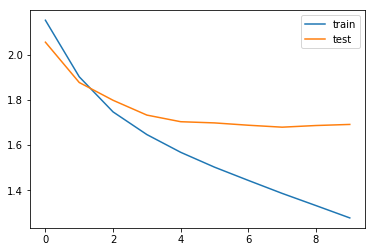

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [50]:
plt.savefig('loss.png')

<Figure size 432x288 with 0 Axes>

In [11]:
model = load_model('newModel.h5', custom_objects={'AttentionLayer' : AttentionLayer})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Create Encoder and Decoder models

In [51]:
enc_model = Model(inputs=encoder_in, outputs=[encoder_out, hidden_state, cell_state])

dec_state_in_hidden = Input(shape=(dim,))
dec_state_in_cell = Input(shape=(dim,))
dec_hidden_state_in = Input(shape=(max_content_len, dim))

dec_emb = decoder_embedding_layer(decoder_in)

dec_out2, hidden_state2, cell_state2 = decoder_lstm(dec_emb, initial_state=[dec_state_in_hidden, dec_state_in_cell])

attention_out_inf, attention_state_inf = attention_layer([dec_hidden_state_in, dec_out2])
dec_inf_concat = Concatenate(axis=-1)([dec_out2, attention_out_inf])

dec_out2 = decoder_dense(dec_inf_concat)

dec_model = Model([decoder_in] + [dec_hidden_state_in, dec_state_in_hidden, dec_state_in_cell], [dec_out2] + [hidden_state2, cell_state2])

In [52]:
enc_model.save('enc_modelNew.h5')
dec_model.save('dec_modelNew.h5')

In [12]:
enc_model = load_model('enc_modelNew.h5', custom_objects={'AttentionLayer' : AttentionLayer})
dec_model = load_model('dec_modelNew.h5', custom_objects={'AttentionLayer' : AttentionLayer})

### Prediction method

In [13]:
def predict(sequence):
    sequence = sequence.reshape(1, max_content_len)
    enc_out, enc_h, enc_c = enc_model.predict(sequence)

    t_sequence = np.zeros((1, 1))
    t_sequence[0, 0] = y_tokenizer.word_index['start']

    dec_seq = ''
    stop = False

    while not stop: 
        out, hidden, cell = dec_model.predict([t_sequence] + [enc_out, enc_h, enc_c])
        sample_index = np.argmax(out[0, -1, :])
        try:
            sample = y_tokenizer.index_word[sample_index]
        except:
            stop = True
            
        if (sample != 'end'):
            dec_seq += ' ' + sample

            if (sample == 'end' or len(dec_seq.split()) >= (max_summary_len - 1)):
                stop = True

        t_sequence = np.zeros((1, 1))
        t_sequence[0, 0] = sample_index

        enc_h, enc_c = hidden, cell

        
    return dec_seq             

### Convert padded vectors back into text format

In [14]:
def get_content(x):
    content = ''
    for i in x:
        if (i != 0):
            content += x_tokenizer.index_word[i] + ' '
    return content

In [15]:
def get_summary(y):
    summary = ''
    for i in y:
        if (i not in [0,1,2]):
            summary += y_tokenizer.index_word[i] + ' '
    return summary

In [16]:
def display(index):
    print("Text: " + get_content(x_test[index]))
    print("\nSummary: " + get_summary(y_test[index]))
    print("\nPredicted Summary:" + predict(x_test[index]))

In [27]:
display(0)

Text: smoking a cigarette will increase your blood pressure for a few minutes and smoking is also very bad for your health overall if you smoke cigarettes your body will be less equipped in general to maintain health as well as experiencing spikes in your blood pressure many people smoke cigarettes to handle stress so it is important to find an alternative stress reliever cigarette smoking can lead to health complications that will also cause you stress and limit your lifestyle cigarettes are expensive and heavily taxed in some areas they can cause financial stress to some people with tight budgets in some cultures and cities there is a social stigma against cigarette smoking experiencing pushback for smoking from your friends or coworkers can cause you stress 

Summary: avoid cigarette smoking 

Predicted Summary: quit smoking


### Calculate ROUGE metric

In [28]:
evaluator = Rouge(metrics=['rouge-l'])

In [29]:
candidates = []
references = []
contents = []

for i in range(len(x_test)):
    contents.append(get_content(x_test[i]))
    candidates.append(predict(x_test[i]))
    references.append(get_summary(y_test[i]))

In [30]:
scores = evaluator.get_scores(candidates, references)

In [31]:
fscores = []
precisions = []
recalls = []

for i in range(len(scores)):
    fscores.append(scores[i]['rouge-l']['f'])
    precisions.append(scores[i]['rouge-l']['p'])
    recalls.append(scores[i]['rouge-l']['r'])

In [32]:
results_df = pd.DataFrame()
results_df['content'] = contents
results_df['reference'] = references
results_df['candidate'] = candidates
results_df['f-score'] = fscores
results_df['precision'] = precisions
results_df['recall'] = recalls

In [33]:
results_df.head()

,content,reference,candidate,f-score,precision,recall
0,smoking a cigarette will increase your blood p...,avoid cigarette smoking,quit smoking,0.371429,0.5,0.333333
1,for example if you want to quit smoking so tha...,alter it so that every benefit of giving up yo...,write down your quit smoking,0.058587,0.2,0.055556
2,having a depressed parent is difficult your fe...,remember that it's okay to cry,avoid emotions,0.000000,0.0,0.000000
3,this is particularly important to do if you li...,wash your hands regularly and maintain good hy...,wash your hands,0.406308,1.0,0.375000
4,after a surgery there will be a number of doct...,offer to go to any follow up exams with your f...,get a referral to a treatment,0.111111,0.2,0.100000


In [17]:
os.chdir(path + '/data')

In [35]:
results_df.to_csv('results.csv', index=None)

In [3]:
results_df = pd.read_csv('results.csv', index_col=None, usecols=['content', 'reference', 'candidate', 'f-score', 'precision', 'recall'])

In [4]:
sorted_results = results_df.sort_values(by=['f-score'], ascending=False)
sorted_results.head()

,content,reference,candidate,f-score,precision,recall
7125,any increase in redness swelling pain or pus i...,watch for signs of infection,watch for signs of infection,1.0,1.0,1.0
743,like endorphins that will improve your mood ex...,exercise,exercise,1.0,1.0,1.0
7559,a great way to give back to the community and ...,volunteer,volunteer,1.0,1.0,1.0
8986,in case you weren't aware smoking is bad news ...,quit smoking,quit smoking,1.0,1.0,1.0
5261,you to acknowledge your thoughts and feelings ...,keep a journal,keep a journal,1.0,1.0,1.0


In [18]:
display(7125)

NameError: name 'x_test' is not defined

In [9]:
display(4603)

4603

### Calculate results and statistics

In [5]:
results_df['f-score'].mean()

0.1437594858072432

In [6]:
ref_summary_lengths = []
cand_summary_lengths = []

for summary in results_df['reference']:
    ref_summary_lengths.append(len(summary.split()))
    
for summary in results_df['candidate']:
    cand_summary_lengths.append(len(summary.split()))

In [7]:
results_df['reference_length'] = ref_summary_lengths
results_df['candidate_length'] = cand_summary_lengths
results_df.head()

,content,reference,candidate,f-score,precision,recall,reference_length,candidate_length
0,smoking a cigarette will increase your blood p...,avoid cigarette smoking,quit smoking,0.371429,0.5,0.333333,3,2
1,for example if you want to quit smoking so tha...,alter it so that every benefit of giving up yo...,write down your quit smoking,0.058587,0.2,0.055556,19,5
2,having a depressed parent is difficult your fe...,remember that it's okay to cry,avoid emotions,0.000000,0.0,0.000000,6,2
3,this is particularly important to do if you li...,wash your hands regularly and maintain good hy...,wash your hands,0.406308,1.0,0.375000,8,3
4,after a surgery there will be a number of doct...,offer to go to any follow up exams with your f...,get a referral to a treatment,0.111111,0.2,0.100000,11,6


In [20]:
results_df['reference_length'].mean()

6.532

In [21]:
results_df['candidate_length'].mean()

4.9765

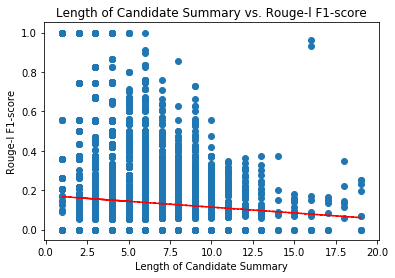

In [35]:
x = results_df['candidate_length']
y = results_df['f-score']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.scatter(x, y)
plt.xlabel("Length of Candidate Summary")
plt.ylabel("Rouge-l F1-score")
plt.title("Length of Candidate Summary vs. Rouge-l F1-score")
plt.show()